In [25]:
import requests
from bs4 import BeautifulSoup
from bs4.element import Comment
import hashlib
import os
import re
from tqdm import tqdm_notebook
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pickle
from operator import itemgetter 
import gensim
import gensim.downloader as api

#!pip install pymorphy2
from pymorphy2 import MorphAnalyzer

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.util import ngrams
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
#урлы парсинга текста для обучения тематической модели
urls = [       
"https://vc.ru/tribuna/133280-kak-my-zapuskali-reputaciyu-servis-dlya-proverki-biznesa-po-115-fz",
"https://habr.com/ru/company/alfa/blog/462977/",
"https://packhacker.ru/karta-roketbank-moj-otzyv-o-karte-dlya-puteshestvij/"]

In [8]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

In [9]:
def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

In [10]:
for url in urls:
  with open(hashlib.sha224(url.encode('utf-8')).hexdigest()+".txt", "w") as f_:
    f_.write(text_from_html(requests.get(url).content))

In [11]:
!ls -a

.
..
17938621c048fb9d80f7c6a579f6a0c90df68eb3fbd2d07a5353e3a4.txt
3b0c258a076caa5b81b282bc694053bc0b82c31f4ba3bfb4bea04763.txt
82fd66dab257b2ff189238601fbfdfaa757f5dfdf1045944f113fb1e.txt
.config
sample_data


In [12]:
texts = []

for file_ in os.listdir():
  if file_ not in ['.config', 'sample_data', '.ipynb_checkpoints', 'lda_model.pkl']:
    with open(file_, "r") as f_:
      texts.append(f_.read())

In [13]:
len(texts)

3

In [14]:
morph = MorphAnalyzer()
stop = set(stopwords.words('russian')+['самый','который','мочь','весь'])
good_types=['VERB','ADJF','NOUN','ADVB']

def lemmatize_texts(texts):
    tokenized_text = []
    for text in tqdm_notebook(texts):
        #tokens = nltk.wordpunct_tokenize(text.lower())
        prog = re.compile(r'[а-яa-z]+')
        tokens = prog.findall(str(text).lower())
        res=[trans_token(tok) for tok in tokens if trans_token(tok)!=None]
        tokenized_text.append(res)
    return tokenized_text

def trans_token(token):
    tok_parse=morph.parse(token)[0]
    if "Geox" in tok_parse.tag:
        res="локация"

        """
        if tok_parse.normal_form in rus_cities:
            res="<рус_город>"
        elif tok_parse.normal_form in rus_regions:
            res="<рус_регион>"
        else:
            res=tok_parse.normal_form
        """


    elif "Surn" in tok_parse.tag:
        res="фамилия"
    elif "Name" in tok_parse.tag:
        res="имя"
    elif ((tok_parse.tag.POS in good_types) \
    and (tok_parse.normal_form not in stop) \
    and (len(token)>2)) or ('LATN' in tok_parse.tag):
         res=tok_parse.normal_form
    else:
        res=None
    return res

In [15]:
lemmatized_texts = lemmatize_texts(texts)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [16]:
# Function to generate n-grams from sentences.
def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]


print("1-gram: ", extract_ngrams(" ".join(lemmatized_texts[0]), 1))
print("2-gram: ", extract_ngrams(" ".join(lemmatized_texts[0]), 2))
print("3-gram: ", extract_ngrams(" ".join(lemmatized_texts[0]), 3))
print("4-gram: ", extract_ngrams(" ".join(lemmatized_texts[0]), 4))

1-gram:  ['главный', 'обзор', 'обзор', 'обзор', 'часы', 'polar', 'vantage', 'обзор', 'мультиспортивный', 'часы', 'suunto', 'итоговый', 'оценка', 'polar', 'vantage', 'm', 'обзор', 'часы', 'polar', 'vantage', 'm', 'скидка', 'скидка', 'следить', 'скидка', 'акция', 'магазин', 'публиковать', 'раздел', 'наш', 'читатель', 'магазин', 'проходить', 'интересный', 'акция', 'опубликовать', 'информация', 'распродажа', 'альпиндустрия', 'распродажа', 'leatherman', 'распродажа', 'фамилия', 'новость', 'новость', 'прошивка', 'polar', 'vantage', 'принести', 'долгожданный', 'функция', 'страна', 'локация', 'виза', 'россиянин', 'список', 'страна', 'требовать', 'международный', 'водительский', 'право', 'блог', 'блог', 'машина', 'локация', 'пингвин', 'имя', 'локация', 'часть', 'прокат', 'авто', 'локация', 'наш', 'опыт', 'хороший', 'угольный', 'гриль', 'weber', 'go', 'anywhere', 'блог', 'карта', 'рокетбанк', 'карта', 'путешествие', 'ленивый', 'написать', 'карта', 'рокета', 'давать', 'постараться', 'плюс', 'роке

In [17]:
id2word = corpora.Dictionary(lemmatized_texts)
texts = lemmatized_texts
corpus = [id2word.doc2bow(text) for text in texts]

In [18]:
#поиск лучше тематической модели по когерентности тем
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):

        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmatized_texts, start=2, limit=40, step=1)

CPU times: user 38.4 s, sys: 10.3 s, total: 48.6 s
Wall time: 35.9 s


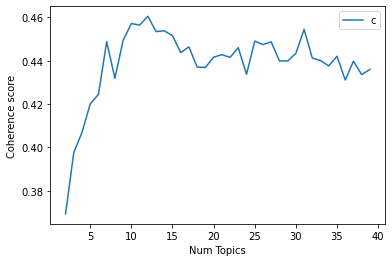

In [20]:
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
#Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3693
Num Topics = 3  has Coherence Value of 0.3976
Num Topics = 4  has Coherence Value of 0.4069
Num Topics = 5  has Coherence Value of 0.4201
Num Topics = 6  has Coherence Value of 0.4245
Num Topics = 7  has Coherence Value of 0.4488
Num Topics = 8  has Coherence Value of 0.4319
Num Topics = 9  has Coherence Value of 0.4495
Num Topics = 10  has Coherence Value of 0.4572
Num Topics = 11  has Coherence Value of 0.4565
Num Topics = 12  has Coherence Value of 0.4606
Num Topics = 13  has Coherence Value of 0.4535
Num Topics = 14  has Coherence Value of 0.4538
Num Topics = 15  has Coherence Value of 0.4516
Num Topics = 16  has Coherence Value of 0.4438
Num Topics = 17  has Coherence Value of 0.4464
Num Topics = 18  has Coherence Value of 0.4371
Num Topics = 19  has Coherence Value of 0.4369
Num Topics = 20  has Coherence Value of 0.4416
Num Topics = 21  has Coherence Value of 0.4428
Num Topics = 22  has Coherence Value of 0.4416
Num Topics = 23  has 

In [22]:
#Num Topics = 24  has Coherence Value of 0.3763
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=24, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
lda_model.print_topics()

[(23,
  '0.001*"робот" + 0.001*"u" + 0.001*"k" + 0.001*"hr" + 0.001*"процесс" + 0.001*"локация" + 0.001*"e" + 0.001*"plus" + 0.001*"сотрудник" + 0.001*"альфа"'),
 (18,
  '0.003*"u" + 0.001*"e" + 0.001*"adfox" + 0.001*"клиент" + 0.001*"c" + 0.001*"id" + 0.001*"b" + 0.001*"label" + 0.001*"p" + 0.001*"provider"'),
 (5,
  '0.001*"u" + 0.001*"локация" + 0.001*"e" + 0.001*"клиент" + 0.001*"adfox" + 0.001*"имя" + 0.001*"p" + 0.001*"карта" + 0.001*"desktop" + 0.001*"b"'),
 (8,
  '0.001*"робот" + 0.001*"k" + 0.001*"локация" + 0.001*"u" + 0.001*"процесс" + 0.001*"сотрудник" + 0.001*"альфа" + 0.001*"имя" + 0.001*"hr" + 0.001*"компания"'),
 (9,
  '0.001*"робот" + 0.001*"локация" + 0.001*"k" + 0.001*"карта" + 0.001*"процесс" + 0.001*"имя" + 0.001*"альфа" + 0.001*"сотрудник" + 0.001*"банка" + 0.001*"hr"'),
 (7,
  '0.003*"u" + 0.001*"adfox" + 0.001*"e" + 0.001*"клиент" + 0.001*"имя" + 0.001*"локация" + 0.001*"p" + 0.001*"c" + 0.001*"desktop" + 0.001*"provider"'),
 (22,
  '0.001*"u" + 0.001*"робот" + 

In [24]:
with open('lda_model.pkl', 'wb') as f:
  pickle.dump(lda_model, f)

In [26]:
api.info("word2vec-ruscorpora-300")

{'base_dataset': 'Russian National Corpus (about 250M words)',
 'checksum': '9bdebdc8ae6d17d20839dd9b5af10bc4',
 'description': 'Word2vec Continuous Skipgram vectors trained on full Russian National Corpus (about 250M words). The model contains 185K words.',
 'file_name': 'word2vec-ruscorpora-300.gz',
 'file_size': 208427381,
 'license': 'https://creativecommons.org/licenses/by/4.0/deed.en',
 'num_records': 184973,
 'parameters': {'dimension': 300, 'window_size': 10},
 'parts': 1,
 'preprocessing': 'The corpus was lemmatized and tagged with Universal PoS',
 'read_more': ['https://www.academia.edu/24306935/WebVectors_a_Toolkit_for_Building_Web_Interfaces_for_Vector_Semantic_Models',
  'http://rusvectores.org/en/',
  'https://github.com/RaRe-Technologies/gensim-data/issues/3'],
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/word2vec-ruscorpora-300/__init__.py'}

In [ ]:
%%time
pre_trained_model = api.load("word2vec-ruscorpora-300")

In [ ]:
pre_trained_model.wv.vocab

In [27]:
def lemm_context_get_POS(x):
    list_ = []
    for elem in x:
        
        if morph.parse(elem)[0].tag.POS == "ADJF" or morph.parse(elem)[0].tag.POS == "ADJS":
            list_.append(elem+"_ADJ")
            
        elif morph.parse(elem)[0].tag.POS == "ADVB":
            list_.append(elem+"_ADV")    
            
        elif morph.parse(elem)[0].tag.POS == "CONJ":
            list_.append(elem+"_CCONJ")  
        
        elif morph.parse(elem)[0].tag.POS == "INTJ":
            list_.append(elem+"_INTJ")
            
        elif morph.parse(elem)[0].tag.POS == "NOUN":
            list_.append(elem+"_NOUN")
            
        elif morph.parse(elem)[0].tag.POS == "NUMR":
            list_.append(elem+"_NUM")
            
        elif morph.parse(elem)[0].tag.POS == "PRCL":
            list_.append(elem+"_PART")
        
        elif morph.parse(elem)[0].tag.POS == "NPRO":
            list_.append(elem+"_PRON")
            
        elif morph.parse(elem)[0].tag.POS == "INFN" or morph.parse(elem)[0].tag.POS == "VERB":
            list_.append(elem+"_VERB")
        
    return list_    

In [ ]:
#!pip install flask-ngrok
#!pip install flask_cors

from flask_ngrok import run_with_ngrok
from flask import Flask
from flask import request
from flask_cors import CORS
import collections
from flask import jsonify


app = Flask(__name__)
run_with_ngrok(app)   #starts ngrok when the app is run
CORS(app)

@app.route("/")
def home():


    with open('lda_model.pkl', 'rb') as f:
      lda_model = pickle.load(f)

    text = request.args.get('text')
    lemmatized_texts = lemmatize_texts([text])
    
    counter = collections.Counter(lemmatized_texts[0])

    d = {}
    d["keywords"] = [word[0] for word in counter.most_common()[:10]]

    corpus = [id2word.doc2bow(text) for text in lemmatized_texts]
    topic_id = max(lda_model.get_document_topics(corpus[0], minimum_probability=0.0), key = itemgetter(1))[0] 
    d["topic_model"] = "+".join(["%s*%f"%(id2word[term[0]], term[1]) for term in lda_model.get_topic_terms(topic_id, topn=10)])

    lemmatized_texts_POS = [lemm_context_get_POS(text) for text in lemmatized_texts]
    slice_step = len(lemmatized_texts_POS[0])//10

    wv = []
    window_=0
    for i in range(10):
      slice_ = lemmatized_texts_POS[0][window_:window_+slice_step]
      vecs= [pre_trained_model.wv[word] for word in slice_ if word in pre_trained_model.wv]
      wv.append(pre_trained_model.most_similar(positive=[np.mean(vecs, axis=0)], topn=10)[0][0])
      window_+=slice_step
    d["vw"] = wv

    return jsonify(d)
  
app.run()